In [1]:
import keras
import keras.backend as K
import tensorflow as tf 
import seaborn as sns
import cv2
import numpy as np 
import pandas as pd
from data_generator import *
from metrics import * 
from preprocess import scale
import matplotlib.pyplot as plt


/Users/hyunkim/.pyenv/versions/3.6.9/envs/python36/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Get file list

In [2]:
IMG_PATHS = "./dataset/img_paths.npy"
img_paths = np.load(IMG_PATHS)
img_paths[:2]

array(['./dataset/selfie/testing/00001.png',
       './dataset/selfie/testing/00002.png'], dtype='<U35')

### Model

In [3]:
# model path for using in EDA
MODEL_PATH = "./trained_models/widerScale/2862-0.05.h5"

In [4]:
from network import network_big
model = network_big((256,256,3), train=True)
print(model.output)
model.summary()

[<tf.Tensor 'output/Sigmoid:0' shape=(None, 256, 256, 1) dtype=float32>, <tf.Tensor 'boundary_attention/Sigmoid:0' shape=(None, 256, 256, 1) dtype=float32>]
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 256, 256, 8)  8           conv2d[0][0]                     
__________________________________________________________________________________________________
separable_conv2d (SeparableCo

In [5]:
model.load_weights(MODEL_PATH, by_name=True)
# model.save('./trained_models/20200813/92_0.12_withGraph.h5')

### Infer on sample image

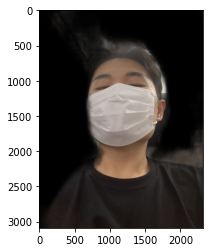

In [6]:
img_file = "/Users/hyunkim/Downloads/IMG_1610.JPG"

img = cv2.imread(img_file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

re_img = cv2.resize(img, (256, 256))
in_img = scale(re_img[np.newaxis,:,:,:])

pred = model.predict(in_img)

h, w, c = img.shape
plt.imshow(np.uint(img * np.expand_dims(cv2.resize(pred[0][0], dsize=(w, h)), -1)))

### Infer on the dataset

In [8]:
input_size = (256, 256)

img_file = np.random.choice(img_paths)

mask_file = img_file.split(".png")[0]+"_matte.png"

img = cv2.imread(img_file, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, input_size)
in_img = scale(img[np.newaxis,:,:,:])

mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, input_size)

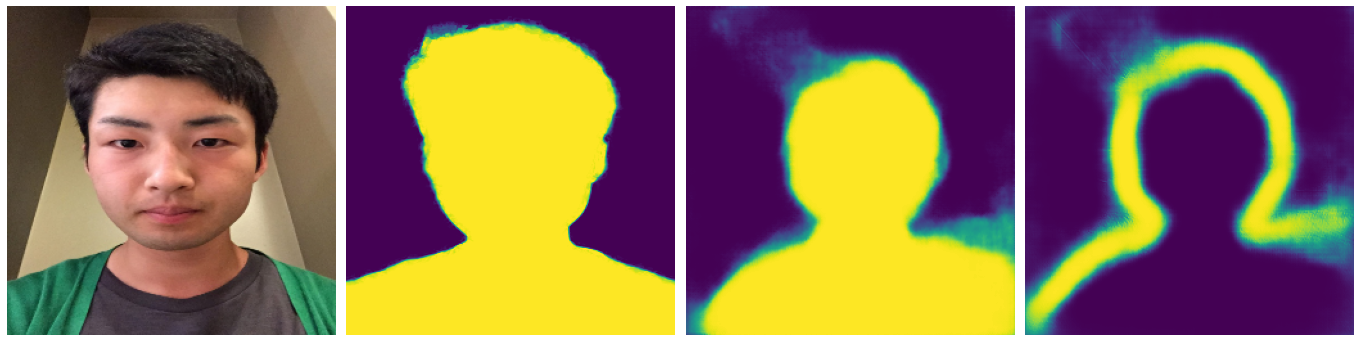

In [9]:
plt.figure(figsize=(19,7))
plt.subplot(141)
plt.imshow(img)
plt.axis("off")

plt.subplot(142)
plt.imshow(mask)
plt.axis("off")

plt.subplot(143)
plt.imshow(cv2.resize(pred[0].squeeze(0).squeeze(-1), tuple(np.array(input_size) * 1)))
plt.axis("off")

plt.subplot(144)
plt.imshow(cv2.resize(pred[1].squeeze(0).squeeze(-1), tuple(np.array(input_size) * 1)))
plt.axis("off")

plt.tight_layout()
plt.show()

#### Convert TFJS Model

In [8]:
# save tf-saved model
tf.saved_model.save(model, "/Users/MAC/Desktop/previous")

INFO:tensorflow:Assets written to: /Users/MAC/Desktop/previous/assets


In [9]:
import tensorflowjs
tensorflowjs.converters.convert_tf_saved_model('/Users/MAC/Desktop/previous', '/Users/MAC/Desktop/tfjs_models')

Writing weight file /Users/MAC/Desktop/tfjs_models/model.json...


--------------

### Find Hard cases

In [13]:
# data feeding logic
test_params = {
            'dim': (256,256),
            'batch_size': 1,
            'n_channels': 3,
            'shuffle': False,
            'augment': False,
            'output_div' : 1,
        }

paths = sorted([p for p in img_paths if 'test' in p])
gen = DataGeneratorMatting(paths, **test_params)

#### 1. Calculate IOU over all the dataset

In [20]:
iou_list = []
for ge in gen:
    g, l = ge
    preds = model.predict(g, verbose=1)
    trues_ = tf.constant(l[0] , dtype=tf.float32)
    preds_ = tf.constant(preds, dtype=tf.float32) 
    iou = iou_coef(trues_, preds_, smooth=1)    
    iou_list.append(iou.numpy()[0])

1/1 [==============================] - 0s 1ms/step


KeyboardInterrupt: 

#### 1. Sort and check its distribution

In [23]:
lowest = np.argsort(iou_list)[:50]
lowest[:20]

array([21,  5, 15, 20,  4,  6, 22, 17, 12, 10, 19, 18, 13,  9,  0,  2,  8,
        3, 11,  1])

/Users/hyunkim/.pyenv/versions/3.6.9/envs/python36/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


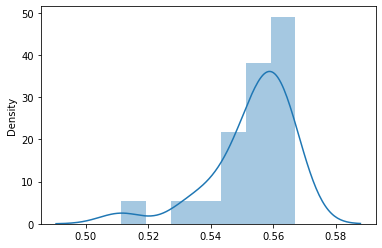

In [26]:
sns.distplot(iou_list)
plt.show()

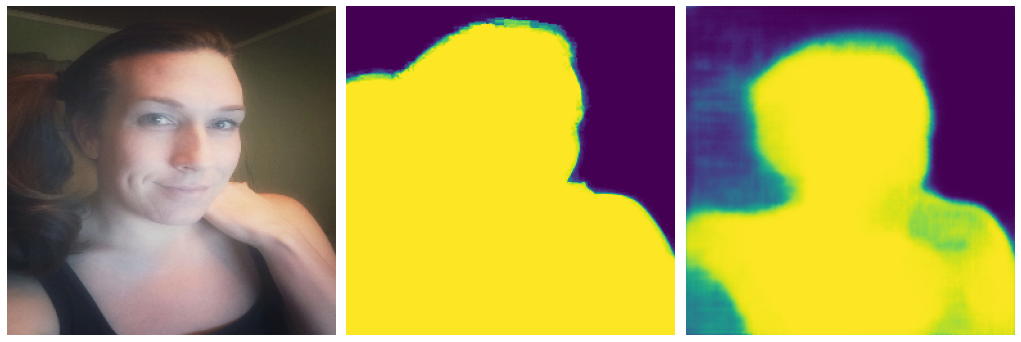

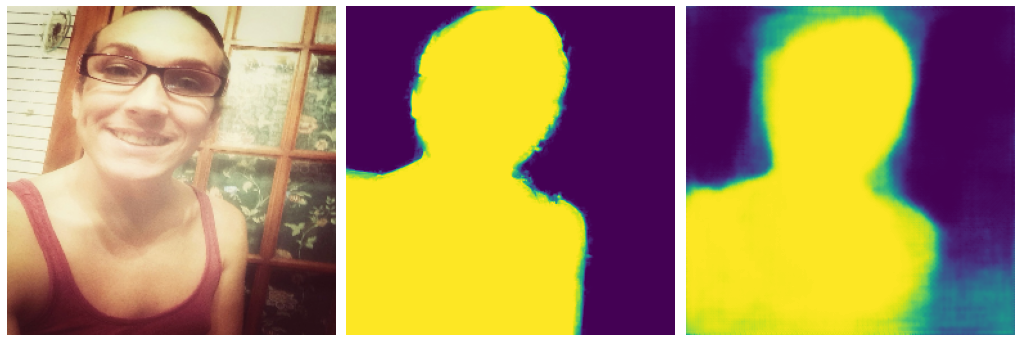

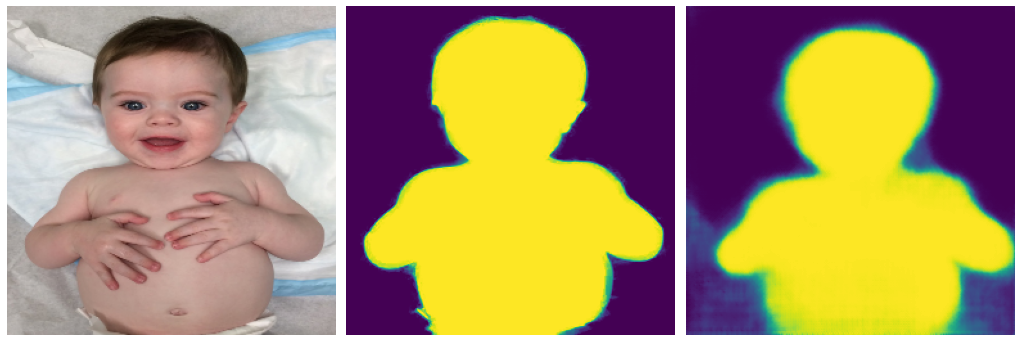

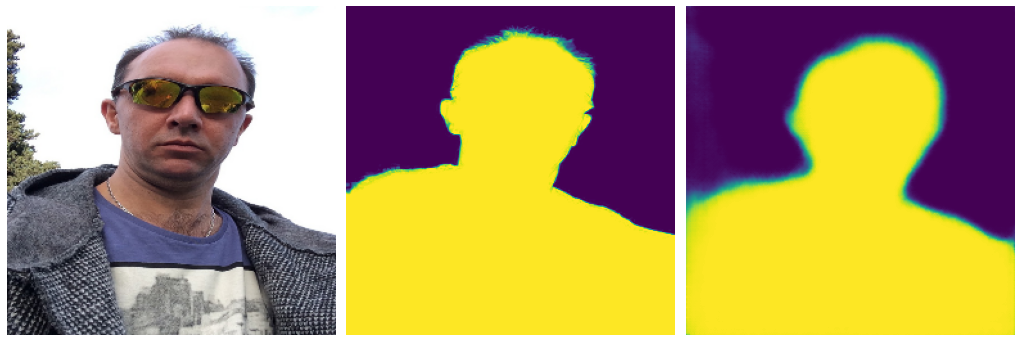

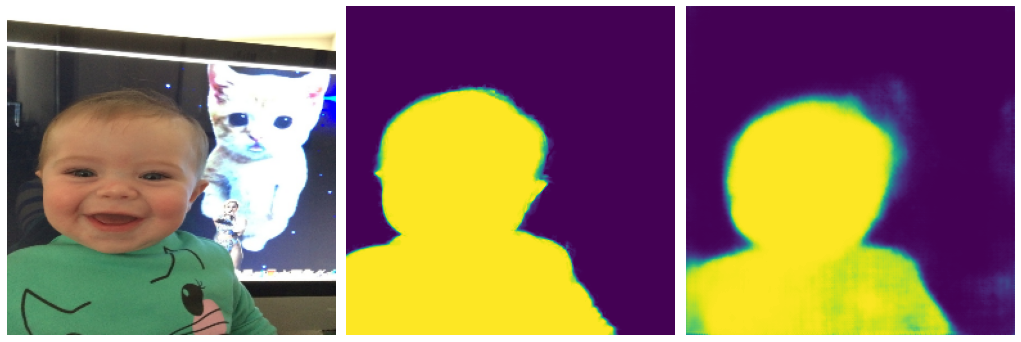

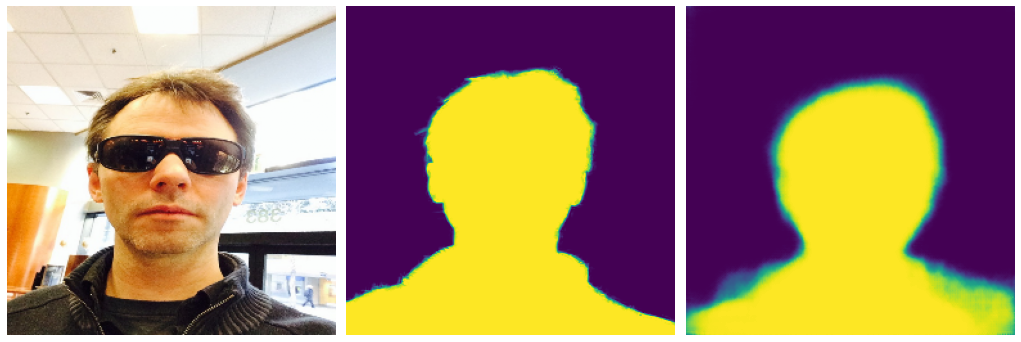

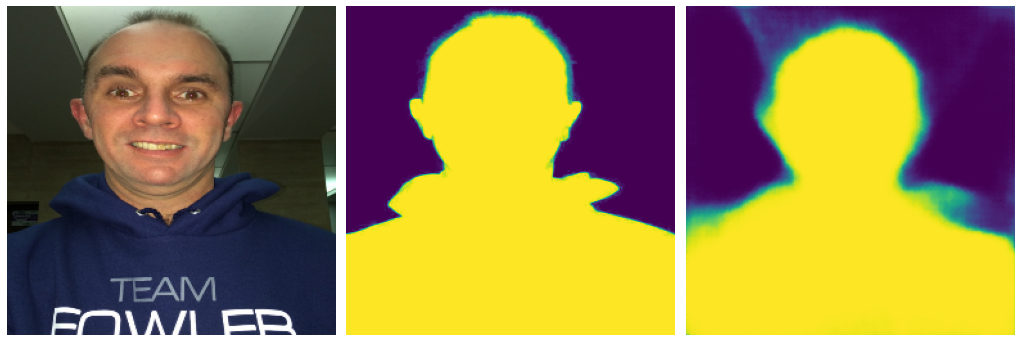

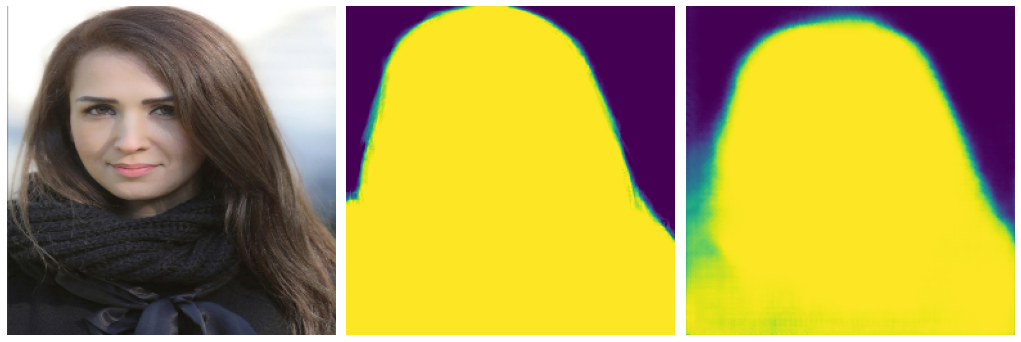

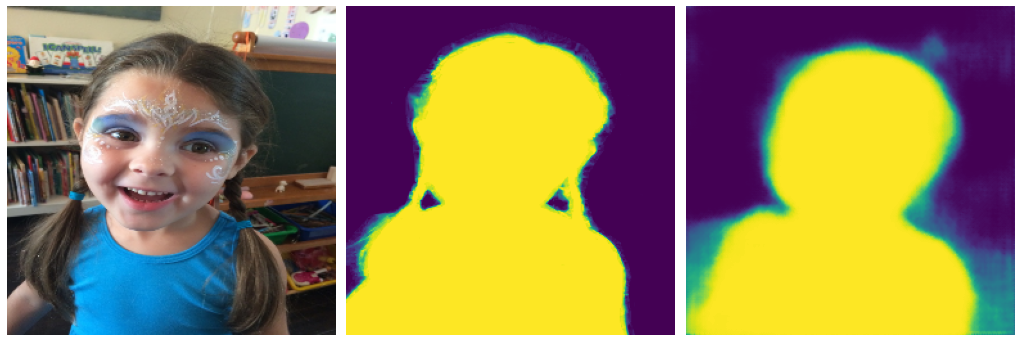

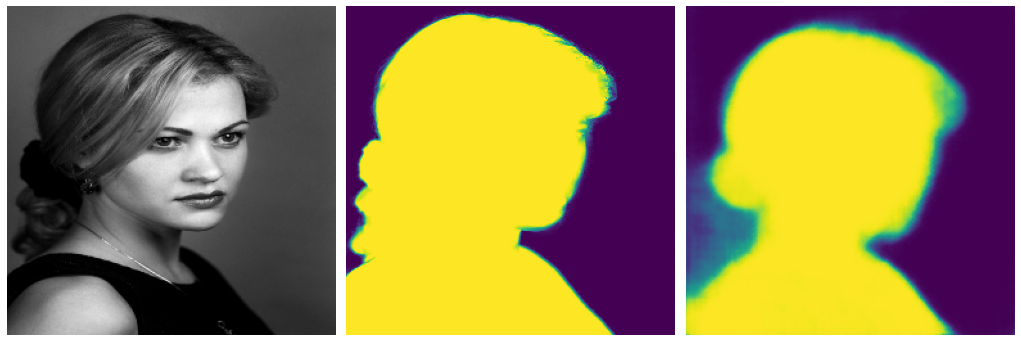

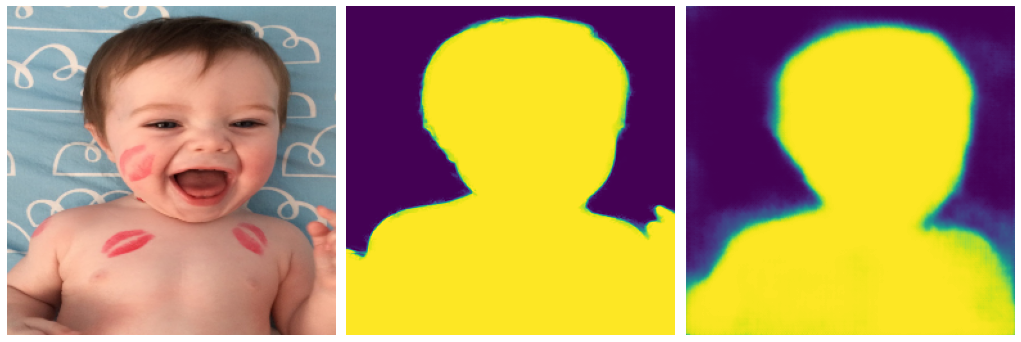

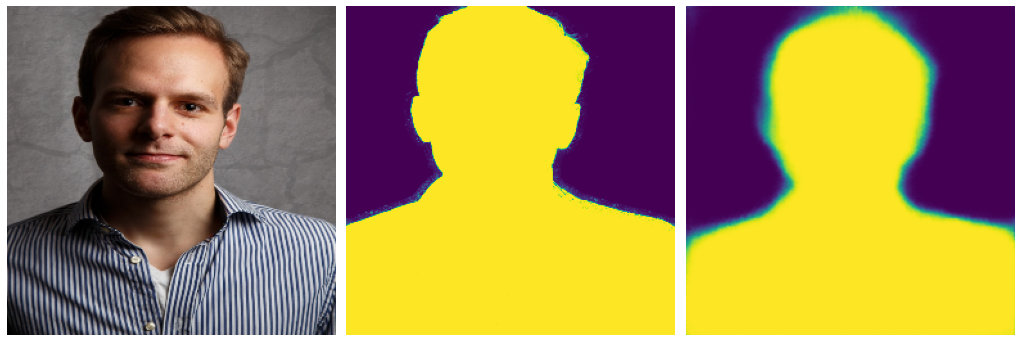

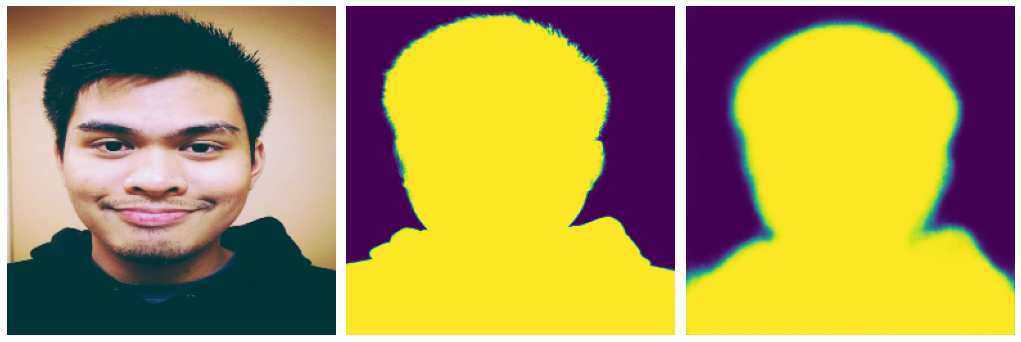

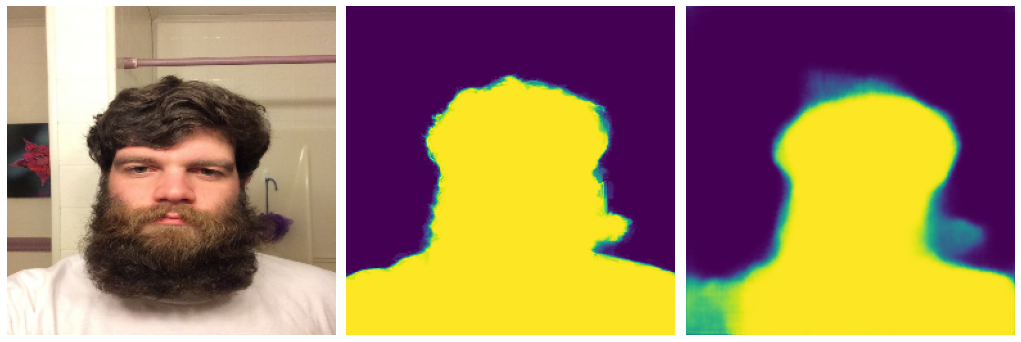

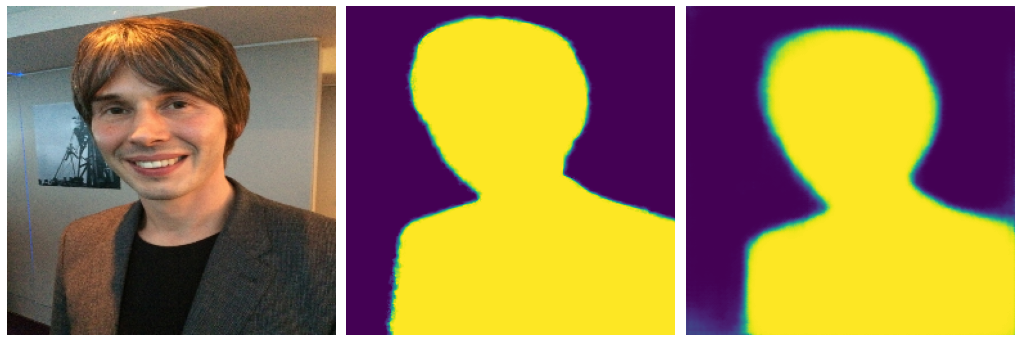

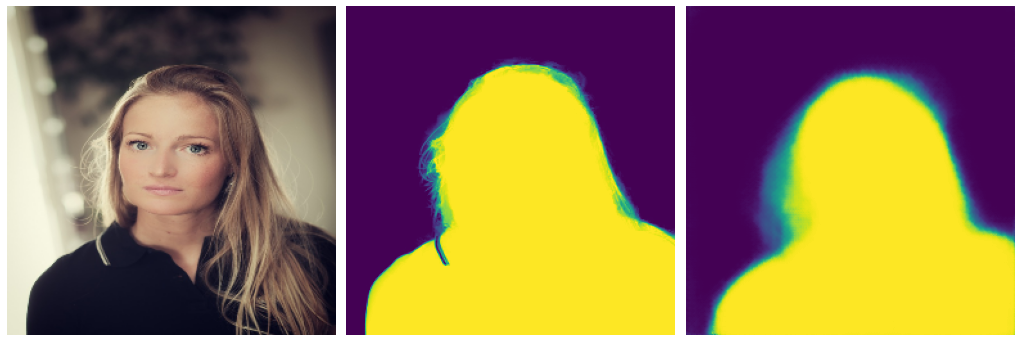

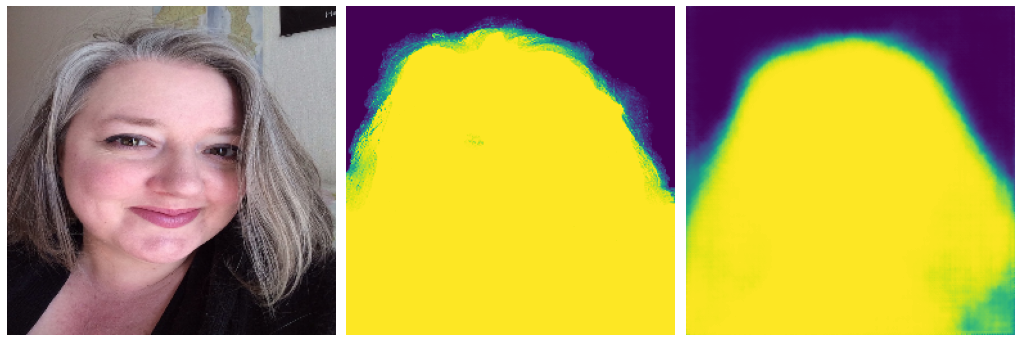

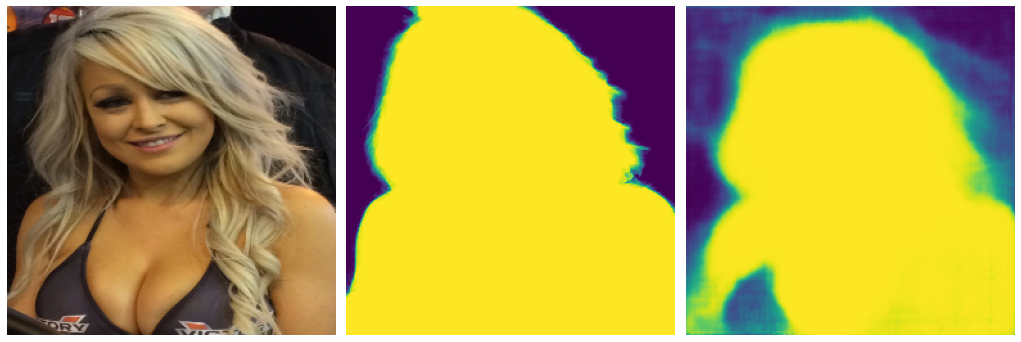

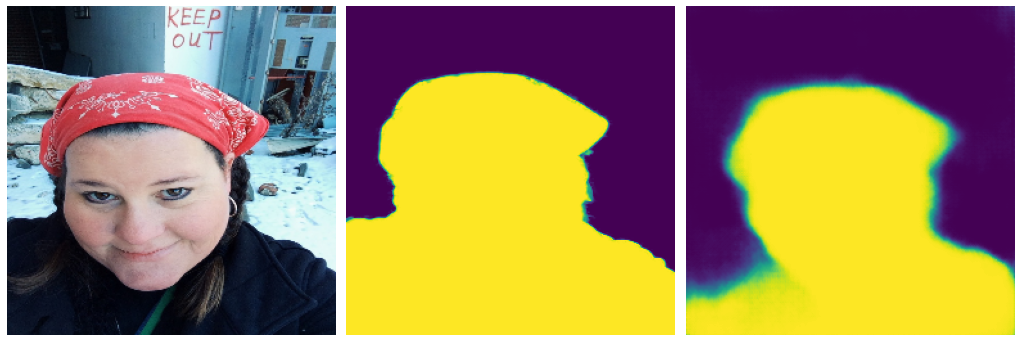

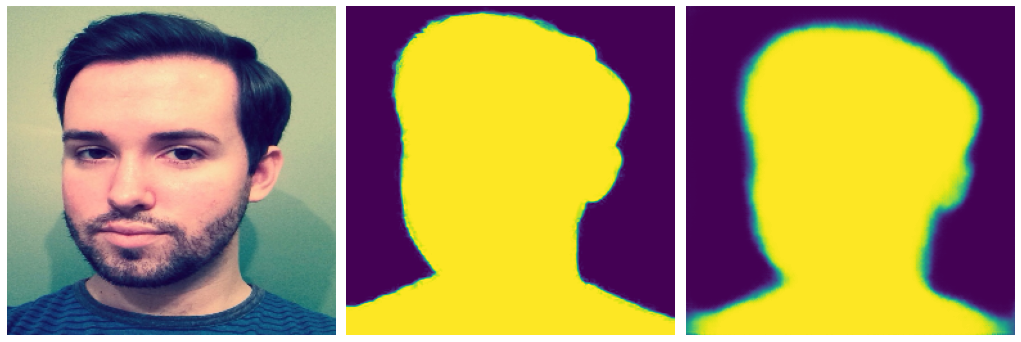

In [33]:
import numpy as np 
import cv2
# import matplotlib.pyplot as plt
for i in lowest[:20]:
    img_path = paths[i]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img = img.astype(np.float32)
    img = img[np.newaxis,:,:,:] / 255.

    mask_path = img_path.split(".p")[0] + "_matte.png"
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256,256))

    pred = model.predict(img)
    
    plt.figure(figsize=(19,7))
    plt.subplot(141)
    plt.imshow(img[0][:,:,:3])
    plt.axis("off")

    plt.subplot(142)
    plt.imshow(mask)
    plt.axis("off")

    plt.subplot(143)
    plt.imshow(pred[0][0])
    plt.axis("off")

    # plt.subplot(144)
    # plt.imshow(pred[1].squeeze(0).squeeze(-1))
    # plt.axis("off")

    plt.tight_layout()
    plt.show()